# Lab04 Neural Networks for Handwritten Digit Recognition (Multiclass)

## 1 - Packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from utils import plt_softmax
%matplotlib widget

import matplotlib.pyplot as plt

plt.style.use('./deeplearning.mplstyle')

import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

tf.autograph.set_verbosity(0)
np.set_printoptions(precision=2)

## 2 - Softmax Function

The softmax function can be written:

$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Where $z = \mathbf{w} \cdot \mathbf{x} + b$ and N is the number of feature / categories in the output layer.

In [2]:
def my_softmax(z):
    """
    Softmax converts a vector of values to a probability distribution.

    Args:
        z (ndarray (N,)): Input data, N features

    Returns:
        a (ndarray (N,)): Softmax of z
    """

    n = len(z)
    a = np.zeros(n)
    ez_sum = 0

    for i in range(n):
        ez_sum += np.exp(z[i])

    for j in range(n):
        a[j] = np.exp(z[j]) / ez_sum

    return a

Below, vary the values of the `z` inputs. Note in particular how the exponential in the numerator magnifies small differences in the values. Note as well that the output values sum to one.

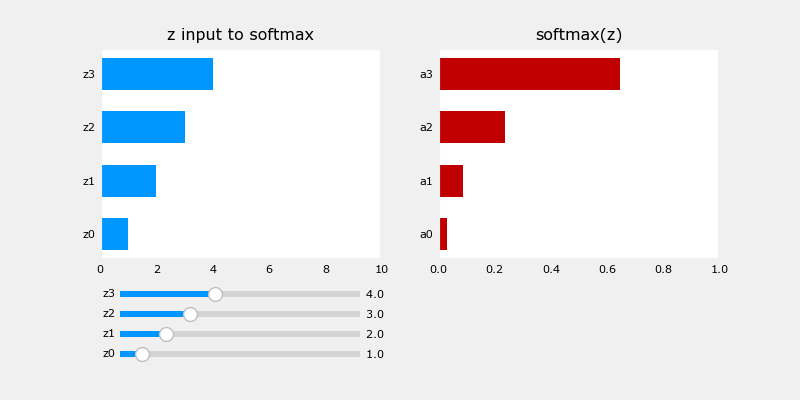

In [3]:
plt.close('all')
plt_softmax(my_softmax)

## 3 - Dataset

You will start by loading the dataset for this task.

- The `load_data()` function shown below loads the data into variables `X` and `y` .
- The data set contains 5000 training examples of handwritten digits.
  - Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
    - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
    - The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector.
    - Each training examples becomes a single row in our data matrix `X`.
    - This gives us a 5000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X =
\left(\begin{array}{cc}
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\
--- (x^{(m)}) ---
\end{array}\right)$$

- The second part of the training set is a 5000 x 1 dimensional vector `y` that contains labels for the training set.
  - `y = 0` if the image is of the digit `0`, `y = 4` if the image is of the digit `4` and so on.

In [4]:
# Load the dataset

def load_data():
    X = np.load('X.npy')
    y = np.load('y.npy')
    return X, y


X, y = load_data()

In [5]:
# View the variables

print('The shape of X is: ' + str(X.shape))
print('The shape of y is: ' + str(y.shape))
print('The first element of X is:', X[0])
print('The first element of y is:', y[0, 0])
print('The last element of y is:', y[-1, 0])

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)
The first element of X is: [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02 

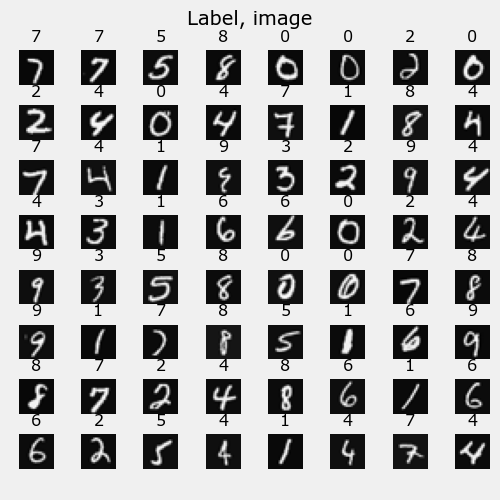

In [6]:
# Visualize the data

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def widgvis(fig):
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False


m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])

widgvis(fig)

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()
    fig.suptitle('Label, image', fontsize=14)

## 4 - Model Representation

The neural network you will use in this lab is below.

- This has two dense layers with ReLU activations followed by an output layer with a linear activation.
  - Recall that our inputs are pixel values of digit images.
  - Since the images are of size $20\times20$, this gives us $400$ inputs.
- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $10$ output units in layer 3, one for each digit.
  - Recall that the dimensions of these parameters is determined as follows:
    - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then
    - $W$ will be of dimension $s_{in} \times s_{out}$.
    - $b$ will be a vector with $s_{out}$ elements.
  - Therefore, the shapes of `W`, and `b`, are
    - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,).
    - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,).
    - layer3: The shape of `W3` is (15, 10) and the shape of `b3` is: (10,).

> **Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention.

## 5 - Tensorflow Model Implementation

In [7]:
tf.random.set_seed(1234)

model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        Dense(25, activation='relu', name='L1'),
        Dense(15, activation='relu', name='L2'),
        Dense(10, activation='linear', name='L3'),
    ], name='my_model'
)

model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Examine Weights shapes

[layer1, layer2, layer3] = model.layers

W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()

print(f'W1 shape = {W1.shape}, b1 shape = {b1.shape}')
print(f'W2 shape = {W2.shape}, b2 shape = {b2.shape}')
print(f'W3 shape = {W3.shape}, b3 shape = {b3.shape}')

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


The following code:

- defines a loss function, `SparseCategoricalCrossentropy` and indicates the softmax should be included with the loss calculation by adding `from_logits=True` .
- defines an optimizer. A popular choice is Adaptive Moment (Adam) which was described in lecture.

In [9]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,
    y,
    epochs=100
)

Epoch 1/100
157/157 [==============================] - 1s 747us/step - loss: 1.6072
Epoch 2/100
157/157 [==============================] - 0s 722us/step - loss: 0.6636
Epoch 3/100
157/157 [==============================] - 0s 728us/step - loss: 0.4205
Epoch 4/100
157/157 [==============================] - 0s 725us/step - loss: 0.3252
Epoch 5/100
157/157 [==============================] - 0s 709us/step - loss: 0.2725
Epoch 6/100
157/157 [==============================] - 0s 703us/step - loss: 0.2361
Epoch 7/100
157/157 [==============================] - 0s 742us/step - loss: 0.2097
Epoch 8/100
157/157 [==============================] - 0s 760us/step - loss: 0.1890
Epoch 9/100
157/157 [==============================] - 0s 754us/step - loss: 0.1749
Epoch 10/100
157/157 [==============================] - 0s 776us/step - loss: 0.1571
Epoch 11/100
157/157 [==============================] - 0s 760us/step - loss: 0.1468
Epoch 12/100
157/157 [==============================] - 0s 741us/step - lo

## 6 - Prediction

Let's compare the predictions vs the labels for a random sample of 64 digits.

1/1 [==============================] - 0s 13ms/step


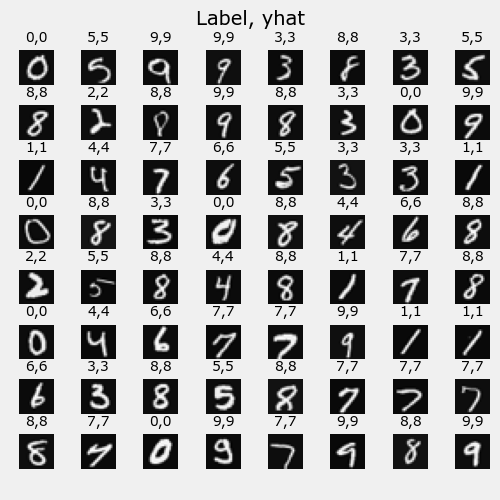

In [10]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])
widgvis(fig)

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    prediction = model.predict(X[random_index].reshape(1, 400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    ax.set_title(f'{y[random_index, 0]},{yhat}', fontsize=10)
    ax.set_axis_off()

fig.suptitle('Label, yhat', fontsize=14)
plt.show()

Let's look at some of the errors.

In [11]:
def display_errors(model, X, y):
    f = model.predict(X)
    yhat = np.argmax(f, axis=1)
    doo = yhat != y[:, 0]
    idxs = np.where(yhat != y[:, 0])[0]

    if len(idxs) == 0:
        print('No errors found')
    else:
        cnt = min(8, len(idxs))
        fig, ax = plt.subplots(1, cnt, figsize=(5, 1.2))
        fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.80])
        widgvis(fig)
        for i in range(cnt):
            j = idxs[i]
            X_reshaped = X[j].reshape((20, 20)).T
            ax[i].imshow(X_reshaped, cmap='gray')
            prediction = model.predict(X[j].reshape(1, 400))
            prediction_p = tf.nn.softmax(prediction)
            yhat = np.argmax(prediction_p)
            ax[i].set_title(f'{y[j, 0]},{yhat}', fontsize=10)
            ax[i].set_axis_off()
            fig.suptitle('Label, yhat', fontsize=12)

    return (len(idxs))


print(f'{display_errors(model, X, y)} errors out of {len(X)} images')

157/157 [==============================] - 0s 508us/step
No errors found
0 errors out of 5000 images
